In [1]:
import wandb
import os
import re

import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid')
%matplotlib inline


def calc_c95(table, value, group_name='name'):

    print(value)
    stats = table.groupby([group_name])[value].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(+ 1.96*s/np.sqrt(c))
        ci95_lo.append(- 1.96*s/np.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    print(stats)
    print('\n')

# Wideness

In [2]:
name = 'mnist_fc_none_200000_0'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == name:
        run_id = run.id
        print(run.name, run.id)
        break

mnist_fc_none_200000_0 puq2f4zd


In [2]:
run_dict = {}

api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == 'mnist_plain_none_50_0':
        run_dict['mnist'] = run
        print(run.name, run.id)
    elif run.name == 'fgsm-mnist_plain_none_50_0':
        run_dict['fgsm-mnist'] = run
        print(run.name, run.id)
    elif run.name == 'pgd-mnist_plain_none_50_0':
        run_dict['pgd-mnist'] = run
        print(run.name, run.id)
        
baseline_dict = {}

for env, run in run_dict.items():
    # train
    if env == 'mnist':
        baseline = pd.DataFrame()
        history = run.history(samples=1000)
        baseline['train_acc'] = history['train_acc'].dropna()
        baseline['epoch'] = history['epoch'].dropna()
    # attack
    else:
        baseline = pd.DataFrame()
        history = run.history(samples=1000)
        baseline['attack_acc'] = history['attack_acc'].dropna()
        baseline['eps'] = history['eps'].dropna()
    baseline_dict[env] = baseline
    print(baseline)

pgd-mnist_plain_none_50_0 z48qvs6s
fgsm-mnist_plain_none_50_0 1v0mv3ch
mnist_plain_none_50_0 1spy9d4x
   attack_acc   eps
0      0.9923  0.00
1      0.9202  0.05
2      0.4940  0.10
3      0.0562  0.15
4      0.0015  0.20
5      0.0000  0.25
6      0.0000  0.30
   attack_acc   eps
0      0.9923  0.00
1      0.9507  0.05
2      0.7981  0.10
3      0.5966  0.15
4      0.3735  0.20
5      0.1806  0.25
6      0.0800  0.30
     train_acc  epoch
59    0.956400    1.0
120   0.984367    2.0
181   0.989500    3.0
242   0.992200    4.0
303   0.994050    5.0
364   0.995117    6.0
425   0.996517    7.0
486   0.997117    8.0
547   0.997817    9.0
608   0.998100   10.0


In [82]:
# find runs
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
print(len(runs))

129


In [40]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp[''] = '${}$'.format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count  std  ci95_hi  ci95_lo
name                                                         
mnist_fc_none_1000    91.163331      1  NaN      NaN      NaN
mnist_fc_none_10000   97.938335      1  NaN      NaN      NaN
mnist_fc_none_100000  99.349999      1  NaN      NaN      NaN
mnist_fc_none_2000    94.046664      1  NaN      NaN      NaN
mnist_fc_none_20000   98.734999      1  NaN      NaN      NaN
mnist_fc_none_200000  99.444997      1  NaN      NaN      NaN
mnist_fc_none_5000    96.490002      1  NaN      NaN      NaN
mnist_fc_none_50000   99.185002      1  NaN      NaN      NaN


best_test_acc
                           mean  count  std  ci95_hi  ci95_lo
name                                                         
mnist_fc_none_1000    92.750001      1  NaN      NaN      NaN
mnist_fc_none_10000   97.119999      1  NaN      NaN      NaN
mnist_fc_none_100000  97.810000      1  NaN      NaN      NaN
mnist_fc_none_2000    94.779998      1 

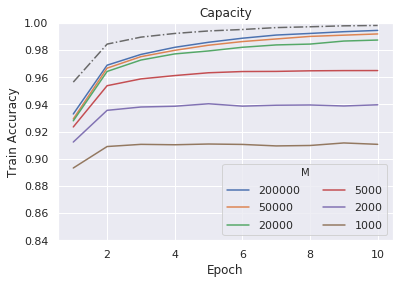

In [41]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$100000$', '$50000$', '$20000$', '$10000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title='Capacity', xlabel='Epoch', ylabel='Train Accuracy')
plt.ylim(0.84, 1.0)
plt.legend(loc='lower right', ncol=2, title='M')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

In [44]:
ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['M'] = "${}$".format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                          mean  count  std  ci95_hi  ci95_lo
name                                                        
pgd-mnist_fc_none_1000    1.89      1  NaN      NaN      NaN
pgd-mnist_fc_none_10000   1.16      1  NaN      NaN      NaN
pgd-mnist_fc_none_100000  0.50      1  NaN      NaN      NaN
pgd-mnist_fc_none_2000    2.41      1  NaN      NaN      NaN
pgd-mnist_fc_none_20000   0.92      1  NaN      NaN      NaN
pgd-mnist_fc_none_200000  1.25      1  NaN      NaN      NaN
pgd-mnist_fc_none_5000    1.97      1  NaN      NaN      NaN
pgd-mnist_fc_none_50000   1.49      1  NaN      NaN      NaN




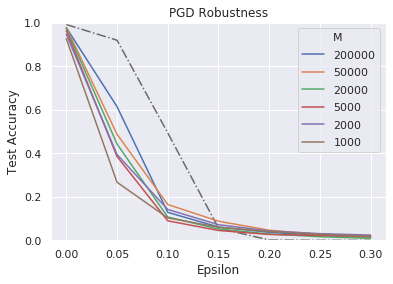

In [45]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgray')
ax = sns.lineplot(x='eps', y='attack_acc', hue='M', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$100000$', '$50000$', '$20000$', '$10000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

# LTD

In [46]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))

    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp['M'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)

        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count  std  ci95_hi  ci95_lo
name                                                         
mnist_fc_ma_1000      92.725003      1  NaN      NaN      NaN
mnist_fc_ma_10000     98.505002      1  NaN      NaN      NaN
mnist_fc_ma_100000    99.343336      1  NaN      NaN      NaN
mnist_fc_ma_2000      95.249999      1  NaN      NaN      NaN
mnist_fc_ma_20000     98.989999      1  NaN      NaN      NaN
mnist_fc_ma_200000    99.431664      1  NaN      NaN      NaN
mnist_fc_ma_5000      97.488332      1  NaN      NaN      NaN
mnist_fc_ma_50000     99.268335      1  NaN      NaN      NaN
mnist_fc_none_1000    91.163331      1  NaN      NaN      NaN
mnist_fc_none_10000   97.938335      1  NaN      NaN      NaN
mnist_fc_none_100000  99.349999      1  NaN      NaN      NaN
mnist_fc_none_2000    94.046664      1  NaN      NaN      NaN
mnist_fc_none_20000   98.734999      1  NaN      NaN      NaN
mnist_fc_none_200000  99.444997      1  NaN      NaN   

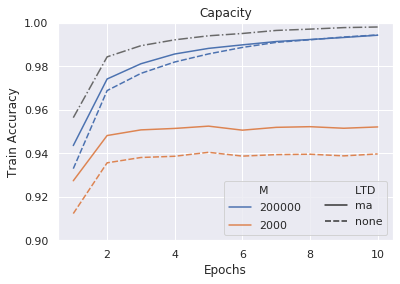

In [47]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='M', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title='Capacity', xlabel='Epochs', ylabel='Train Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

In [50]:
ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['M'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                           mean  count  std  ci95_hi  ci95_lo
name                                                         
pgd-mnist_fc_ma_1000      15.60      1  NaN      NaN      NaN
pgd-mnist_fc_ma_10000     11.36      1  NaN      NaN      NaN
pgd-mnist_fc_ma_100000    11.35      1  NaN      NaN      NaN
pgd-mnist_fc_ma_2000      16.95      1  NaN      NaN      NaN
pgd-mnist_fc_ma_20000     11.35      1  NaN      NaN      NaN
pgd-mnist_fc_ma_200000    11.35      1  NaN      NaN      NaN
pgd-mnist_fc_ma_5000      19.32      1  NaN      NaN      NaN
pgd-mnist_fc_ma_50000     11.35      1  NaN      NaN      NaN
pgd-mnist_fc_none_1000     1.89      1  NaN      NaN      NaN
pgd-mnist_fc_none_10000    1.16      1  NaN      NaN      NaN
pgd-mnist_fc_none_100000   0.50      1  NaN      NaN      NaN
pgd-mnist_fc_none_2000     2.41      1  NaN      NaN      NaN
pgd-mnist_fc_none_20000    0.92      1  NaN      NaN      NaN
pgd-mnist_fc_none_200000   1.25      1  NaN      NaN   

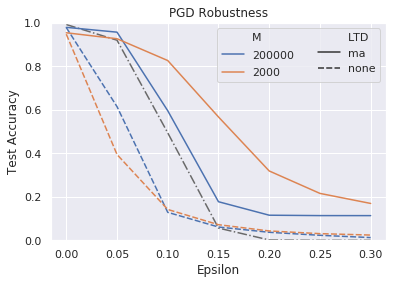

In [51]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='eps', y='attack_acc', hue='M', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

# Sparseness

In [72]:
# ENV = 'mnist'
# K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]
ENV = 'cifar10'
K = [1, 2, 4, 10, 20, 50, 100, 400, 1200, 3072]
METHOD = ['rc']
LTD = ['ma']

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        ltd = m.group(4)
        n = int(m.group(5))
        seed = int(m.group(6))

        if env == ENV and method in METHOD and k in K and ltd in LTD:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['best_train_acc'] = history['best_train_acc'].dropna()
            temp['best_test_acc'] = history['best_test_acc'].dropna()
            temp['Granule'] = method
            temp['K'] = k
            temp['seed'] = seed
            df = df.append(temp)

            best_train_acc = history['best_train_acc'].dropna().item() * 100
            best_test_acc = history['best_test_acc'].dropna().item() * 100
            name = run.name[:-2]
            table = table.append(pd.DataFrame(
                {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                              mean  count  std  ci95_hi  ci95_lo
name                                                            
cifar10_rc-100_ma_40000  56.436002      1  NaN      NaN      NaN
cifar10_rc-10_ma_160000  51.958001      1  NaN      NaN      NaN
cifar10_rc-1200_ma_3934  51.889998      1  NaN      NaN      NaN
cifar10_rc-1_ma_228571   41.363999      1  NaN      NaN      NaN
cifar10_rc-20_ma_120000  53.320003      1  NaN      NaN      NaN
cifar10_rc-2_ma_218182   48.106000      1  NaN      NaN      NaN
cifar10_rc-3072_ma_1563  43.619999      1  NaN      NaN      NaN
cifar10_rc-400_ma_11429  56.818002      1  NaN      NaN      NaN
cifar10_rc-4_ma_200000   49.950001      1  NaN      NaN      NaN
cifar10_rc-50_ma_68571   54.967999      1  NaN      NaN      NaN


best_test_acc
                              mean  count  std  ci95_hi  ci95_lo
name                                                            
cifar10_rc-100_ma_40000  50.489998      1  NaN      NaN    

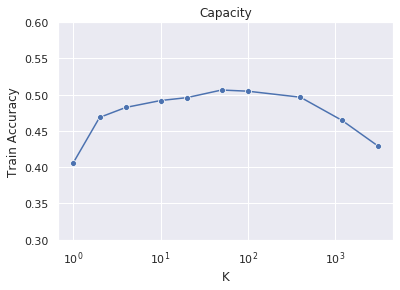

In [77]:
ax = sns.lineplot(x='K', y='best_test_acc', ci=95, n_boot=1000, marker='o',
                  data=df)
ax.set(title='Capacity', xlabel='K', xscale='log', ylabel='Train Accuracy')
plt.ylim(0.3, 0.6)
# plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300)

In [104]:
ATTACK = 'fgsm'
# ENV = ATTACK + '-mnist'
# K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]
ENV = ATTACK + '-cifar10'
K = [1, 2, 4, 10, 20, 50, 100, 400, 1200, 3072]

METHOD = ['rc']
LTD = ['ma']
SEED = [0, 1]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        ltd = m.group(4)
        n = int(m.group(5))
        seed = int(m.group(6))

        if env == ENV and method in METHOD and k in K and ltd in LTD and seed in SEED:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['attack_acc'] = history['attack_acc'].dropna()
            temp[''] = history['eps'].dropna().apply(
                lambda x: '${}$'.format(int(x * 255)))
            temp['K'] = k
            temp['Granule'] = method
            temp['seed'] = seed
            df = df.append(temp)

            max_attack_acc = history['max_attack_acc'].dropna().item() * 100
            name = run.name[:-2]
            table = table.append(pd.DataFrame(
                {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                               mean  count  std  ci95_hi  ci95_lo
name                                                             
fgsm-cifar10_rc-100_ma_40000   6.41      1  NaN      NaN      NaN
fgsm-cifar10_rc-10_ma_160000   9.10      1  NaN      NaN      NaN
fgsm-cifar10_rc-1200_ma_3934   3.51      1  NaN      NaN      NaN
fgsm-cifar10_rc-1_ma_228571    5.03      1  NaN      NaN      NaN
fgsm-cifar10_rc-20_ma_120000   8.80      1  NaN      NaN      NaN
fgsm-cifar10_rc-2_ma_218182   10.24      1  NaN      NaN      NaN
fgsm-cifar10_rc-3072_ma_1563   2.43      1  NaN      NaN      NaN
fgsm-cifar10_rc-400_ma_11429   4.61      1  NaN      NaN      NaN
fgsm-cifar10_rc-4_ma_200000   11.07      1  NaN      NaN      NaN
fgsm-cifar10_rc-50_ma_68571    7.01      1  NaN      NaN      NaN




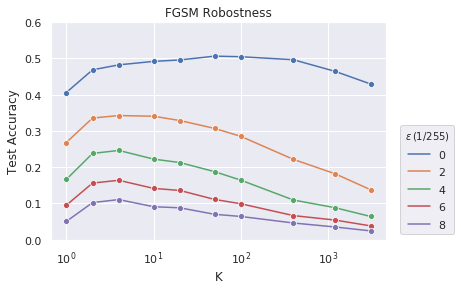

In [108]:
ax = sns.lineplot(x='K', y='attack_acc', hue='', ci=95, n_boot=1000, marker='o',
                  data=df)
ax.set(title=ATTACK.upper() + ' Robostness', xlabel='K', xscale='log', ylabel='Test Accuracy')
# plt.ylim(0.0, 1.0)
# lgd = plt.legend(loc='lower right', title='$\epsilon$', bbox_to_anchor=(1.22, 0))
plt.ylim(0.0, 0.6)
lgd = plt.legend(loc='lower right', title='$\epsilon\,(1/255)$', bbox_to_anchor=(1.22, 0))
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Cerebellum

In [70]:
ENV = 'mnist'
MODEL = {'plain_none_50': 'CNN', 
         'rc-4_ma_200000': 'Cerebellum',
         'rc-4_none_200000': 'No LTD',
         'fc_ma_5970': 'No Sparse',
         'fc_none_5970': 'Base'}


df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*_.*_.*)_(.*)', run.name)
    env = m.group(1)
    model = m.group(2)
    seed = int(m.group(3))
    
    if env == ENV and model in MODEL.keys():
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp[''] = MODEL[model]
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                             mean  count  std  ci95_hi  ci95_lo
name                                                           
mnist_fc_ma_5970        97.833335      1  NaN      NaN      NaN
mnist_fc_none_5970      97.248334      1  NaN      NaN      NaN
mnist_plain_none_50     99.809998      1  NaN      NaN      NaN
mnist_rc-4_ma_200000    96.385002      1  NaN      NaN      NaN
mnist_rc-4_none_200000  94.726664      1  NaN      NaN      NaN


best_test_acc
                             mean  count  std  ci95_hi  ci95_lo
name                                                           
mnist_fc_ma_5970        97.039998      1  NaN      NaN      NaN
mnist_fc_none_5970      96.550000      1  NaN      NaN      NaN
mnist_plain_none_50     99.229997      1  NaN      NaN      NaN
mnist_rc-4_ma_200000    96.259999      1  NaN      NaN      NaN
mnist_rc-4_none_200000  94.910002      1  NaN      NaN      NaN




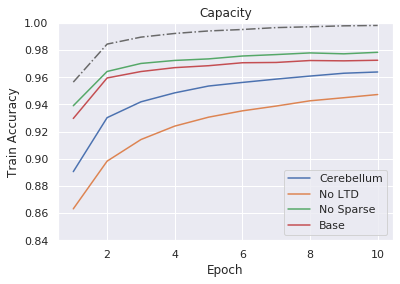

In [71]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['Cerebellum', 'No LTD', 'No Sparse', 'Base'],
                  data=df)
ax.set(title='Capacity', xlabel='Epoch', ylabel='Train Accuracy')
plt.ylim(0.84, 1.0)
plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/cereb_'+ENV+'.png', dpi=300)

In [78]:
# ATTACK = 'fgsm'
# ENV = ATTACK + '-mnist'
# MODEL = {'plain_none_50': 'CNN', 
#          'rc-4_ma_200000': 'Cerebellum',
#          'rc-4_none_200000': 'No LTD',
#          'fc_ma_5970': 'No Sparse',
#          'fc_none_5970': 'Base',
#          'rc-10_ma_160000': 'Best'}

ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
MODEL = {'plain_none_50': 'CNN', 
         'rc-4_ma_200000': 'Cerebellum',
         'rc-4_none_200000': 'No LTD',
         'fc_ma_5970': 'No Sparse',
         'fc_none_5970': 'Base',
         'rc-2_ma_218182': 'Best'}


df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*_.*_.*)_(.*)', run.name)
    env = m.group(1)
    model = m.group(2)
    seed = int(m.group(3))
    
    if env == ENV and model in MODEL.keys():
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp[''] = MODEL[model]
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                             mean  count  std  ci95_hi  ci95_lo
name                                                           
pgd-mnist_fc_ma_5970        26.71      1  NaN      NaN      NaN
pgd-mnist_fc_none_5970       1.32      1  NaN      NaN      NaN
pgd-mnist_plain_none_50      0.00      1  NaN      NaN      NaN
pgd-mnist_rc-2_ma_218182    76.11      1  NaN      NaN      NaN
pgd-mnist_rc-4_ma_200000    56.87      1  NaN      NaN      NaN
pgd-mnist_rc-4_none_200000   1.67      1  NaN      NaN      NaN




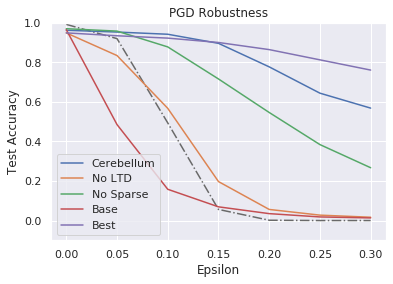

In [80]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='eps', y='attack_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['Cerebellum', 'No LTD', 'No Sparse', 'Base', 'Best'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(-0.1, 1.0)
plt.legend(loc='lower left')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/cereb_'+ENV+'.png', dpi=300)